# PySpark - Preparing the Data For Modeling

## Introduction

This project will venture into building machine learning models by using the PySpark's MLlib module. It should be noted that it is now being deprecated as it is being moved to the ML module. However, if the datasets used are to be stored on RDDs, it is still possible to utilise the MLlib for machine learning work. 

## Breakdown of this Notebook

- Loading the Dataset
- Exploring the Dataset
- Testing the Dataset
- Transforming the Dataset
- Standardising the Dataset
- Creating RDDs for Training
- Predicting hours of work for census respondents
- Forecasting the income level of census respondents
- Building a clustering model
- Computing the performance statistics


## Dataset:

For this project, the dataset can be found in the "Datasets" folder, where it is sourced from http://archive.ics.uci.edu/ml/datasets/Census+Income. The CSV file that is used is called "". \
Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset. 

Alternative source: https://www.kaggle.com/uciml/adult-census-income/data

Included in the "Datasets" folder is two files:
- adults.csv
- census_income_dataset.csv

## 1 PySpark Machine Configuration:

Here it only uses two processing cores from the CPU, and it set up by the following code.

In [1]:
%%configure
{
    "executorCores" : 4
}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,None,pyspark,idle,,,


In [2]:
from pyspark.sql.types import *

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2 Setup the Correct Directory:

In [3]:
import os

# Change the Path:
path = '++++your working directory here++++/Datasets/'
os.chdir(path)
folder_pathway = os.getcwd()

# print(folder_pathway)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 3 Loading in the Dataset:

The dataset will be the 1994 census income data.

In [4]:
# Set the path to the dataset:
dataset_path = path + 'Datasets/census_income_dataset.csv'

# Load in the data:
census_income_dat = spark.read.csv(dataset_path, header = True, inferSchema = True)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# Inspect: 
census_income_dat.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- label: string (nullable = true)

By checking directly with the CSV file on Excel, it can be seen that the datatype for each of the columns were detected properly with the "inferSchema" parameter set to "True".

In [6]:
# Inspect the row data:
census_income_dat.take(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(age=39, workclass=' State-gov', fnlwgt=77516, education=' Bachelors', education-num=13, marital-status=' Never-married', occupation=' Adm-clerical', relationship=' Not-in-family', race=' White', sex=' Male', capital-gain=2174, capital-loss=0, hours-per-week=40, native-country=' United-States', label=' <=50K'), Row(age=50, workclass=' Self-emp-not-inc', fnlwgt=83311, education=' Bachelors', education-num=13, marital-status=' Married-civ-spouse', occupation=' Exec-managerial', relationship=' Husband', race=' White', sex=' Male', capital-gain=0, capital-loss=0, hours-per-week=13, native-country=' United-States', label=' <=50K')]

#### Problem:

From the above print out of the Row() objects, it can be seen that there are trailing white spaces like: workclass=' State-gov'. __This needs to be corrected__.

## 3.1 Fix the Trailing White Spaces:

### Import the required libraries:

In [7]:
import pyspark.sql.functions as f

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Loop through the columns: remove the tailing white spaces on the left and right.
for col, typ in census_income_dat.dtypes:
    if ( typ == 'string' ):
        census_income_dat = census_income_dat.withColumn(col, f.ltrim(f.rtrim(census_income_dat[col])))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
# Inspect the row data:
census_income_dat.take(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(age=39, workclass='State-gov', fnlwgt=77516, education='Bachelors', education-num=13, marital-status='Never-married', occupation='Adm-clerical', relationship='Not-in-family', race='White', sex='Male', capital-gain=2174, capital-loss=0, hours-per-week=40, native-country='United-States', label='<=50K'), Row(age=50, workclass='Self-emp-not-inc', fnlwgt=83311, education='Bachelors', education-num=13, marital-status='Married-civ-spouse', occupation='Exec-managerial', relationship='Husband', race='White', sex='Male', capital-gain=0, capital-loss=0, hours-per-week=13, native-country='United-States', label='<=50K')]

#### Observation:

It can be seen that the problem has now been fixed. For example, workclass='State-gov'.

## 4 Exploring the Dataset:

This section will explore the different aspects of the dataset.

## 4.1 Select the Numerical and Categorical features:

To do this:
- First, check out the columns' dtypes.
- Create a list of columns that are to be kept.
- Here, the 'label' column is important as it keeps track of the person regardless of income.
- Create a DataFrame with the selected columns and extract the numerical and categorical columns.

In [10]:
# Inspect the dtypes of each column:
census_income_dat.dtypes

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('age', 'int'), ('workclass', 'string'), ('fnlwgt', 'int'), ('education', 'string'), ('education-num', 'int'), ('marital-status', 'string'), ('occupation', 'string'), ('relationship', 'string'), ('race', 'string'), ('sex', 'string'), ('capital-gain', 'int'), ('capital-loss', 'int'), ('hours-per-week', 'int'), ('native-country', 'string'), ('label', 'string')]

In [11]:
# List all the columns of interests:
cols_keep = census_income_dat.dtypes

cols_keep = (
    ['label', 'age', 'capital-gain', 'capital-loss', 'hours-per-week'] + 
    [element[0] for element in cols_keep[:-1] if element[1] == 'string']
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# Separate the numerical and categorical features:
census_subset = census_income_dat.select(cols_keep)

# Numerical:
cols_num = [element[0] for element in census_subset.dtypes if element[1] == 'int']

# Categorical:
cols_cat = [element[0] for element in census_subset.dtypes if element[1] == 'string']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 4.2 Numerical Features:

For numerical features, some basic descriptive statistics can be calculated.

### Import the required Libraries:

In [13]:
import pyspark.mllib.stat as st
import numpy as np

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Descriptive Statistics:

To do this:

- First, subset the data for the inclusion of only numerical columns and extract the RDD. A list is created with the .map() function as every element of the RDD is a Row() object.
- Use the statistic package from MLlib to call the .colStats() function to input the RDD numerical values.
- Print out the descriptive statistics.

In [14]:
# Create the RDD:
rdd_num = (
    census_subset
    .select(cols_num)
    .rdd
    .map(lambda row: [element for element in row])
)

# Run the MLlib statistics package:
stats_num = st.Statistics.colStats(rdd_num)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Print the descriptive statistics:
for col, min_, mean_, max_, var_ in zip(cols_num, stats_num.min(), stats_num.mean(), stats_num.max(), stats_num.variance()):
    print('{0}: min->{1: .1f}, mean->{2: .1f}, max->{3: .1f}, stdev->{4: .1f}'.format(col, min_, mean_, max_, np.sqrt(var_)))
    

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

age: min-> 17.0, mean-> 38.6, max-> 90.0, stdev-> 13.6
capital-gain: min-> 0.0, mean-> 1077.6, max-> 99999.0, stdev-> 7385.3
capital-loss: min-> 0.0, mean-> 87.3, max-> 4356.0, stdev-> 403.0
hours-per-week: min-> 1.0, mean-> 40.4, max-> 99.0, stdev-> 12.3

#### Observation:

The average age can be seen to be 39 years old. But there seem to be an outlier here that is 90 years old. 
Comparing the capital gain and loss, it would seem like poeple are making more money than losing it. 
It can also be seen that the average working hours are 40 hours.

## 4.3 Categorical Features:

For categorical features, it should be noted that __not possible__ to calculate simple descriptive statistics. Therefore, the frequencies for each of teh distinct values in the categorical columns must be calculated instead.

To do this:
- First, subset the data for only the categorical columns and its labels (person identifier). Extract the underlying RDD and transform each of the Row() objects into a list. 
- Next, store these results as a dictionary.
- Loop through all the columns and then aggregate the data by using the .groupBy() function. 
- Create a list of tuples where the first element is value "element1[0]" and the second element is the frequenqy (lenght) of "element1[1]".

In [16]:
# Create the RDD:
rdd_cat = (
    census_subset
    .select(cols_cat + ['label'])
    .rdd
    .map(lambda row: [element for element in row])
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# Inspect:
rdd_cat.take(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[['<=50K', 'State-gov', 'Bachelors', 'Never-married', 'Adm-clerical', 'Not-in-family', 'White', 'Male', 'United-States', '<=50K']]

In [18]:
# Save to dictionary:
results_cat = {}

for i, col in enumerate(cols_cat + ['label']):
    results_cat[col] = (
        rdd_cat
        .groupBy(lambda row: row[i])
        .map(lambda element: [element[0], len(element[1])])
        .collect()
    )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# Inspect:
for i in results_cat:
    print(i, results_cat[i], "\n")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

label [['<=50K', 24720], ['>50K', 7841]] 

workclass [['State-gov', 1298], ['Self-emp-not-inc', 2541], ['Private', 22696], ['Federal-gov', 960], ['Local-gov', 2093], ['?', 1836], ['Self-emp-inc', 1116], ['Without-pay', 14], ['Never-worked', 7]] 

education [['Bachelors', 5355], ['HS-grad', 10501], ['11th', 1175], ['Masters', 1723], ['9th', 514], ['Some-college', 7291], ['Assoc-acdm', 1067], ['Assoc-voc', 1382], ['7th-8th', 646], ['Doctorate', 413], ['Prof-school', 576], ['5th-6th', 333], ['10th', 933], ['1st-4th', 168], ['Preschool', 51], ['12th', 433]] 

marital-status [['Never-married', 10683], ['Married-civ-spouse', 14976], ['Divorced', 4443], ['Married-spouse-absent', 418], ['Separated', 1025], ['Married-AF-spouse', 23], ['Widowed', 993]] 

occupation [['Adm-clerical', 3770], ['Exec-managerial', 4066], ['Handlers-cleaners', 1370], ['Prof-specialty', 4140], ['Other-service', 3295], ['Sales', 3650], ['Craft-repair', 4099], ['Transport-moving', 1597], ['Farming-fishing', 994], ['Machi

#### Observation:

The values for each key in each of the columns are not sorted, let's fix this by sorting for the values and not the keys.

In [20]:
for i in results_cat:
    print(i, sorted(results_cat[i], key = lambda element: element[1], reverse = True), "\n")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

label [['<=50K', 24720], ['>50K', 7841]] 

workclass [['Private', 22696], ['Self-emp-not-inc', 2541], ['Local-gov', 2093], ['?', 1836], ['State-gov', 1298], ['Self-emp-inc', 1116], ['Federal-gov', 960], ['Without-pay', 14], ['Never-worked', 7]] 

education [['HS-grad', 10501], ['Some-college', 7291], ['Bachelors', 5355], ['Masters', 1723], ['Assoc-voc', 1382], ['11th', 1175], ['Assoc-acdm', 1067], ['10th', 933], ['7th-8th', 646], ['Prof-school', 576], ['9th', 514], ['12th', 433], ['Doctorate', 413], ['5th-6th', 333], ['1st-4th', 168], ['Preschool', 51]] 

marital-status [['Married-civ-spouse', 14976], ['Never-married', 10683], ['Divorced', 4443], ['Separated', 1025], ['Widowed', 993], ['Married-spouse-absent', 418], ['Married-AF-spouse', 23]] 

occupation [['Prof-specialty', 4140], ['Craft-repair', 4099], ['Exec-managerial', 4066], ['Adm-clerical', 3770], ['Sales', 3650], ['Other-service', 3295], ['Machine-op-inspct', 2002], ['?', 1843], ['Transport-moving', 1597], ['Handlers-cleaners'

#### Observation:

Taking a look at the "sex", there seem to be an imbalance in genders where the male is almost twice as much in count when compared to females. Another thing to note is that under "race", the data is also skewed and have a greater count of "White" people. Additionally, it can be seen under "label" that there were significantly more people earning more than $50K.

## 4.4 Correlations with MLlib:

This section will explore the correlations between numerical variables.

Note: the .corr() method here does return a NumPy array(s) or matrix where each of the elements can be either a Pearson (default) or Spearman correlation coefficient.

In [21]:
# Calculate the correlations:
corr_num = st.Statistics.corr(rdd_num)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
# Inspect:
corr_num

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[ 1.        ,  0.0776745 ,  0.05777454,  0.06875571],
       [ 0.0776745 ,  1.        , -0.03161506,  0.07840862],
       [ 0.05777454, -0.03161506,  1.        ,  0.05425636],
       [ 0.06875571,  0.07840862,  0.05425636,  1.        ]])

In [23]:
cols_num

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['age', 'capital-gain', 'capital-loss', 'hours-per-week']

In [24]:
# Print out the calculations: Taking the upper triangular portion of the matrix without the diagonal values.
for i, el_i in enumerate(abs(corr_num) > 0.05):
    print(cols_num[i])
#     print(el_i)
    
    for j, el_j in enumerate(el_i):
        if el_j and j != i:
            print("     ", cols_num[j], corr_num[i][j])
    print()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

age
      capital-gain 0.07767449816599513
      capital-loss 0.05777453947897402
      hours-per-week 0.06875570750946958

capital-gain
      age 0.07767449816599513
      hours-per-week 0.07840861539013481

capital-loss
      age 0.05777453947897402
      hours-per-week 0.054256362272651674

hours-per-week
      age 0.06875570750946958
      capital-gain 0.07840861539013481
      capital-loss 0.054256362272651674

#### Observation:

Majority of the correlations found are less than 0.5, where most are less than 0.1. This means that the features are not highly correlated with each other and presents to be useful for the model. This avoids the issue of __multicollinearity__. 

The follwoing is taken from: https://www.statisticshowto.datasciencecentral.com/multicollinearity/

Multicollinearity generally occurs when there are high correlations between two or more predictor variables. In other words, one predictor variable can be used to predict the other. This creates redundant information, skewing the results in a regression model

## 5 Testing the Data:

A good machine learning model that works well is one where the model is able to generalise well by being simple enough in terms of complexity, but not too simple to the point that it looses its ability to predict. The following diagrams will demonstrate this:

Img Ref -> https://docs.aws.amazon.com/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.html


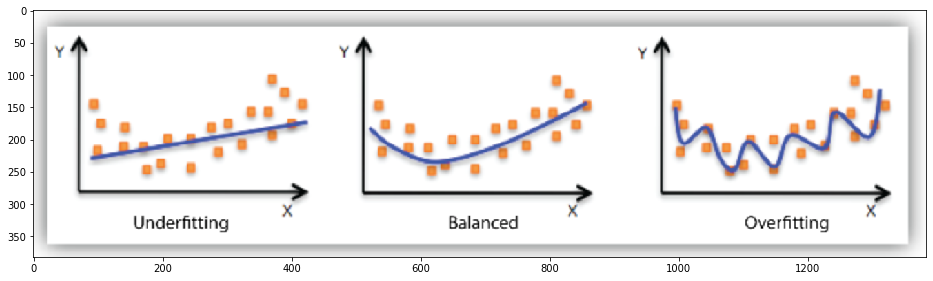

In [25]:
%%local

# Import the required library and set to use ggplot:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

folder_pathway = os.getcwd()

# print(folder_pathway)

image_path = folder_pathway + "/Description Images/"
# plot the image
fig, ax1 = plt.subplots(figsize=(16,12))
image = mpimg.imread(image_path + 'Testing the model_fit.png')
plt.imshow(image);

print('Img Ref -> https://docs.aws.amazon.com/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.html')

#### Underfitting:

Taking a look at the image on the __left__, it shows the model is underfitting the data and looses its ability to predict. In other words, it means that it won't be able to model the data and won't be able to generalise on new data which leads to poor performance. In normal circumstances during model evaluation, it is easy to detect this kind of model behaviour which can be remedied quickly. The remedy is to try an alternative machine learning algorithm(s). 

#### Overfitting:

Taking a look at the image on the __right__, it shows the model is overfitting the data where it fits the training data too well. This ususally happens when the model learns both the details and the noise within the training dataset, to the point where there is a negative impact on the model performance. The noise or random fluctuations within the training data is learned as concepts by the model. This means that it also looses its ability to generalise well on new data.

It should be noted that the occurance of overfitting is more likely with non-parametric and that non-linear models, as these have more flexibility to learn the target function. To solve this, most of the non-parametric machine learning algorithms have additional parameters/techniques to limit and constrain the amount of detail the model learns. For example, decision trees ( anon-parametric algorithm) is highly flexible and is subject to overfitting during training. This is solved by pruning a tree after training to remove some of the details pikced up by the model.

#### Good fit:

Taking a look at the image on the __middle__, it shows the model is able to fit the data at the sweet spot, that is between over and under-fitting. In practice, this can be difficult to obtain. The sweet spot is the point just before the error on the test dataset begins to increase, where the model is able to fit on both the training dataset and the unseen test dataset. There are more methods/techniques to improve the model and find this sweet spot in practice: 

- Select the features wisely.
- Model selection, choose a model that is less prone to overfitting.
- Tune the hyperparameters.
- Resampling methods of the dataset and run multiple model estimations.
- a validation dataset.

Source: https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/

### Here for now, the focus will be on "Selecting the features wisely".

## 5.1 Finding the Best features:

First, is to understand the problem that is being dealt with. As there are different methods that can be used for selecting features for regression problems or classifiers.

- __Regression__:

The target (or ground truth) is a Conitnuous variable. for example, number of work hours per week. There are __2 methods__ to select the best features.
    - Pearson's Correlation -> The correlation is calculated between two Numerical (continuous) features.
    - Analysis of Variance (ANOVA) -> It is a tool that explains and tests the distribution of the observations conditional on some categories. To select the most discriminatory (categorical) features of the continuous dependent variable.

- __Classification__:

The target (or label) is a discrete variable of tow (binomial) or many (multinomial) levels. There are __2 methods__ to select the best features.
    - Linear Discriminant Analysis (LDA) -> Finds a linear combination of continuous features that best explains the variance of the categorical label.
    - Chi Squared Test -> It is a test that tests the independence between two categorical variables.
    
DO NOTE: Spark right now allows to test and select the best features between comparable variables, which means it only implements the Correlations " pyspark.mllib.stat.Statistics.corr(...) " and Chi Squared Test " pyspark.mllib.stat.Statistics.chiSqTest(...) or the pyspark.mllib.feature.ChiSqSelector(...) ".

## 5.2 Import the required Libraries:

In [26]:
import pyspark.mllib.linalg as ln

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 5.3 Chi Squared Test:

Using the .chiSQTest() method to test the independence between the label (the indicator that a person is earning >= $50K) and the occupation of the Census responder.

To do this:
- First, build a pivot table that will group by the occupation feature and pivot it by the label column (it can be either <= USD50K or >= USD50K). For each of the occurance, it is counted.
- Next, flatten the output by extracting the data from the RDD and select the counts (.map(lambda row: (row[1:])) of the map transformation. This is followed by collecting all the data to the driver, so that it can be used to create a DenseMatrix.
- Once the data is on the Driver, proceed to create the matrix representation. The matrix should have 15 rows and 2 columns. Firstly, check the number of distinct iccupation values by checking the count of the "census_occupation" element. Next, call the DenseMatrix() function to create the matrix. This should take in 4 parameters, where the first one is the number of rows, the second one is the number of columns, the third one is the data and the fourth one is if the data is transposed or not. 
- Next, call the ".chiSqTest()" to pass the matrix in. 
- Lastly, check the p-value and the null hypothesis (to be rejected or not)

### Hypothesis:

The distribution of occupation between those that earn more than USD50K vs. those that earn less than USD50K is the __NOT__ the same.

### Null Hypothesis:

The distribution of occupation between those that earn more than USD50K vs. those that earn less than USD50K is the same.


In [27]:
# Build the Pivot Table:
census_occupation = (
    census_income_dat
    .groupby('occupation')
    .pivot('label')
    .count()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
# Inspect:
census_occupation

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[occupation: string, <=50K: bigint, >50K: bigint]

In [29]:
# Flatten the data:
census_occupation_coll = (
    census_occupation
    .rdd
    .map(lambda row: (row[1:]))
    .flatMap(lambda row: row)
    .collect()
    
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
# Inspect:
census_occupation_coll

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[2667, 983, 2098, 1968, 2281, 1859, 1284, 86, 879, 115, 3170, 929, 1277, 320, 148, 1, 438, 211, 3158, 137, 645, 283, 1752, 250, 8, 1, 1652, 191, 3263, 507]

In [33]:
# Create the Matrix Representation:
len_row = len(census_occupation.collect())

dense_Matrix = ln.DenseMatrix(len_row, 2, census_occupation_coll, True)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
# Perform the Chi Squeared Test:
chi_sq = st.Statistics.chiSqTest(dense_Matrix)

# Print the P-Value and the Null-Hypothesis:
print("P-value: ", chi_sq.pValue)
print(chi_sq.nullHypothesis)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

P-value:  0.0
the occurrence of the outcomes is statistically independent.

### Observation:

Here the P-value found was 0.0, it means that the Null Hypothesis can be rejected. A small p-value indicates that the observations are inconsistent with the Null hypothesis. 

It also means that the occurrence of the outcomes is statistically independent, that is that the occupation should be a strong indicator for a person that earns more than USD50K.

## 6 Transforming the Data:

To build the ML model, the data utilised have to be in numeric form. In this case, most of the features in this datasaet are __Categorical__ and therefore it requires to be transformed. The apporach is to use a hashing trick and dummy encoding.

To do this:
- First, loop through all the categorical features and append a tuple of the column name and count the distinct values that are found in each column. 
- Next, use the hashing trick. Where the first thing is to import the required package. The next this is to subset the dataset to extract the relevant columns.
- Next, use the .map() function on the RDD, where for each of the element, enumerate all the columns and if the index of the column is greater >= 5, a new instance of .HashingTF() is created. This can be used to transform the value and converted to NumPy array.
- The .HashingTF() has a parameter that specifies the number of output elements, where in this case, half of the number of distinct values, but by doing so, there will be hashing collisions. 



## 6.1 Transform by reducing the dimensionality of the Dataset by Half:

In [50]:
# Extract the total number of distinct values in each column:
len_features = []

for col in cols_cat:
    (
        len_features
        .append( (col, census_income_dat.select(col).distinct().count()) )
    )

len_features = dict(len_features)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
# Inspect:
len_features

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'label': 2, 'workclass': 9, 'education': 16, 'marital-status': 7, 'occupation': 15, 'relationship': 6, 'race': 5, 'sex': 2, 'native-country': 42}

In [51]:
# For each feautre, use Hashing trick to encode the data:

# Import the required libraries:
import pyspark.mllib.feature as feat

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
# Categorical Columns:
cols_keep

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['label', 'age', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

In [52]:
final_data = (
    census_income_dat
    .select(cols_keep)
    .rdd
    .map(lambda row: [
        list( feat.HashingTF( int(len_features[col] / 2.0) ).transform(row[i]).toArray()
        ) if i >= 5 else [row[i]] for i, col in enumerate(cols_keep)
    ])
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
# Inspect:
final_data.take(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[['<=50K'], [39], [2174], [0], [40], [1.0, 2.0, 1.0, 5.0], [3.0, 3.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [2.0, 3.0, 8.0], [0.0, 3.0, 3.0, 1.0, 4.0, 1.0, 0.0], [5.0, 5.0, 3.0], [3.0, 2.0], [4.0], [1.0, 0.0, 0.0, 3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0]], [['<=50K'], [50], [0], [0], [13], [4.0, 3.0, 1.0, 8.0], [3.0, 3.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [5.0, 5.0, 8.0], [0.0, 1.0, 2.0, 2.0, 8.0, 1.0, 1.0], [4.0, 2.0, 1.0], [3.0, 2.0], [4.0], [1.0, 0.0, 0.0, 3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0]], [['<=50K'], [38], [0], [0], [40], [2.0, 2.0, 0.0, 3.0], [2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0], [3.0, 2.0, 3.0], [2.0, 3.0, 1.0, 3.0, 7.0, 0.0, 1.0], [5.0, 5.0, 3.0], [3.0, 2.0], [4.0], [1.0, 0.0, 0.0, 3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0]]]

## 6.2 Encode the Label:

The label is still a categorical variable which also needs to be transformed. The label has only two values and can be seen to be the first column of each row.

To do this:
- First, the UDF encode_label() function takes an input that is the label, and checks if it is ">50k", where if yes, it will return a Boolean true or otherwise false.
- This is then also converted to integers.
- Next, map the data with this encode_label function by using the .map() method. The first element to pass is the label in each row. 
- Then, in addition to the label data, lopp through the remaining lists of row data and combine them together.

In [56]:
# User Define func:
def encode_label(label):
    return [int(label[0] == '>50K')]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
# Apple the UDF:
final_data = (
    final_data
    .map(lambda row: encode_label(row[0]) + [item for sublist in row[1:] for item in sublist])
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 7 Standardising the data:

